# Network dynamics


### Variable definitions
* $N$ = Node number
* $T$ = Simulation time in [ms]
* $dt$ = Time step for the function in [ms]
* $g$ = $f$ parameter
* $\tau$ = Characteristic Time
* $J$ = Adjacency weighted matrix


### AmariWilsonCowan Model
With:
$$f(x)=\tanh(gx)$$
Model expression:
$$\frac{dV_i}{dt} = -\frac{V_i(t)}{\tau} +\sum_{j=1}^NJ_{ij}f(V_j(t))+\epsilon \xi_i(t)$$
Vector form
\begin{equation}
\frac{dV_i}{dt} = -\frac{\textbf{V(t)}}{\tau}+\textbf{J}f(\textbf{V})+\textbf{S}(t)
\end{equation}
Observable:
$$m(t) = \frac{1}{N}\sum_i^N V_i$$

#### System's Jacobian $(i,k)=(row, column)$ being $Fi=F(V_i(t))$ and $\delta$ Kronecker delta:
$$\frac{\partial F_i}{\partial V_k} = -\frac{1}{\tau}\frac{\partial V_i}{\partial V_k} + \sum_{j=1}^N J_{ij}\frac{\partial f(V_j)}{V_k}$$
$$\frac{\partial F_i}{\partial V_k} = -\frac{\delta{ik}}{\tau} + \sum_{j=1}^N J_{ij} f'(V_j)\frac{\partial f(V_i)}{V_k}$$
$$\frac{\partial F_i}{\partial V_k} = -\frac{\delta{ik}}{\tau} + \sum_{j=1}^N J_{ij} f'(V_j)\delta{jk}$$
$$\frac{\partial F_i}{\partial V_k} = -\frac{\delta{ik}}{\tau} +J_{ik}f'(V_k)$$
$$f'(x) = \tanh(gx) = g(1-\tanh^2(gx))$$

Given that $J_{ii} \forall i = 0$, the Jacobian matrix is:
$$\frac{\partial F_i}{\partial V_k} = -\frac{\delta{ij}}{\tau} +J_{ik}g(1-\tanh^2(gV_k))$$

Matrix form:
$$\Lambda(V)_{ik} = f'(V_k)\delta_{ik} \rightarrow \Lambda(V) = \text{Diag}(g*(1-\tanh^2(gV)))$$
\begin{equation}
DF_V = \frac{-\textbf(I_N)}{\tau} + J\Lambda(V)
\end{equation}
#### Prelude to susceptibility

Adding a perturbation $\xi$ of $\omega$ frequency, to the simulation with $\epsilon ~ 10^{-2}$
2 Cases are needed, $V^{(*)}$ represents the potential with the $\xi$ replaced.
$$V^{(1)} = \xi_i(t) = \xi_i^{(1)}(t) = \imath\cos(\omega t) \delta_{ii_0} $$
$$V^{(2)} = \xi_i(t) = \xi_i^{(2)}(t) = -\sin(\omega t)\delta_{ii_0} $$

#### Obtaining the Susceptibility matrix $\chi$:
$$\chi_{ii_0} = \frac{1}{\tau\epsilon} \sum_{t=0}^Te^{\imath\omega t}[V_{i}^{(1)}(t) + \imath V_i^{2}(t)] $$
$$\chi_{ii_0}(\omega) = \chi_{ii_0}^{(r)}(\omega) + \imath \chi_{ii_0}^{(\imath)}(\omega) \rightarrow |\chi_{ii_0}(\omega)|^2$$

Expected results for a fixed $i,i_0$ and variable $\omega$:
* Peak of FFT of susceptibility on the $\omega$ frequency with varying amplitude based on the node selected.

Conditions:
* Periodical system status

# TODO
### Notes
* Use the J matrix "J2" for tests with the g parameter being (0.15 **P**eriodic | 0.45 **Q**uasi **P**eriodic | 0.8 **C**haotic)
## Lyapunov
* Find a viable code
* Show the spectrum (3-5 coefs) as a function of g
* Ideal plot: lyapunovs v/s g (long) and 4 attractors (columns) below each with M and fft with shared X
## FFT
* Compute and save the FTT for each state, with high T for better resolution (Crop at 50Hz)
## Chi Matrix $\chi$
* Compute and save the $\chi$ matrix with a finer $\omega$ resolution to match FTT plot.
* Compare the peaks obtained (Expected: P and QP to be same peaks and extra peaks from $\chi$ in C)
* Compute the matrix $C$ (Correlations between FTT's) from FTT without stimulus and compare to $\chi$


In [8]:
%matplotlib inline

In [1]:
import ipywidgets

In [2]:
from scipy import spatial #lattices
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
#import networkx as nx #initial graph
from ipywidgets import interact,interact_manual
import scipy
import numba
from numba import jit


eps = 0.01
pii = np.pi*2


@numba.jit(nopython=True)
def dFv(J,V,g,Tau):
    return np.eye(N)*(-1/Tau)+J@np.diag(g*(1-np.tanh(g*V)**2))

@numba.jit(nopython=True)
def S1(omega,t,i0,eps):
    out = np.zeros(N)
    out[i0] = np.cos(omega*t*pii)*eps
    return out

@numba.jit(nopython=True)
def S2(omega,t,i0,eps):
    out = np.zeros(N)
    out[i0] = np.sin(omega*t*pii)*eps
    return out

@numba.jit(nopython=True)
def dV1(V,J,g,Tau,t,omega,i0,eps):
    return -V/Tau + J@f1(V,g) + S1(omega,t,i0,eps)

@numba.jit(nopython=True)
def dV2(V,J,g,Tau,t,omega,i0,eps):
    return -V/Tau + J@f1(V,g) + S2(omega,t,i0,eps)

@numba.jit(nopython=True)
def RK4V1(n,dt,y0,J,g,Tau,omega,i0,eps):
    y = np.zeros((int(n), len(y0)), np.float64)
    tt = 0
    y[0] = y0
    for i in range(int(n) - 1):
        k1 = dV1(y[i],J,g,Tau,tt+dt*n,omega,i0,eps)
        k2 = dV1(y[i] + k1 * dt / 2.,J,g,Tau,tt+dt*n+dt/2,omega,i0,eps)
        k3 = dV1(y[i] + k2 * dt / 2.,J,g,Tau,tt+dt*n+dt/2,omega,i0,eps)
        k4 = dV1(y[i] + k3 * dt,J,g,Tau,tt+dt*n+dt,omega,i0,eps)
        y[i+1] = y[i] + (dt / 6.) * (k1 + 2*k2 + 2*k3 + k4)
        tt+=dt
    return y


@numba.jit(nopython=True)
def RK4V2(n,dt,y0,J,g,Tau,omega,i0,eps):
    y = np.zeros((int(n), len(y0)), np.float64)
    y[0] = y0
    tt = 0
    for i in range(int(n) - 1):
        k1 = dV2(y[i],J,g,Tau,tt+dt*n,omega,i0,eps)
        k2 = dV2(y[i] + k1 * dt / 2.,J,g,Tau,tt+dt*n+dt/2,omega,i0,eps)
        k3 = dV2(y[i] + k2 * dt / 2.,J,g,Tau,tt+dt*n+dt/2,omega,i0,eps)
        k4 = dV2(y[i] + k3 * dt,J,g,Tau,tt+dt*n+dt,omega,i0,eps)
        y[i+1] = y[i] + (dt / 6.) * (k1 + 2*k2 + 2*k3 + k4)
        tt+=dt
    return y

@numba.jit(nopython=True)
def f1(x,g):
    return np.tanh(g*x)


@numba.jit(nopython=True)
def dV(V,J,g,Tau):
    return -V/Tau + J@f1(V,g)


@numba.jit(nopython=True)
def RK4(n,dt,y0,J,g,Tau):
    y = np.zeros((int(n), len(y0)), np.float64)
    y[0] = y0
    for i in range(int(n) - 1):
        k1 = dV(y[i],J,g,Tau)
        k2 = dV(y[i] + k1 * dt / 2.,J,g,Tau)
        k3 = dV(y[i] + k2 * dt / 2.,J,g,Tau)
        k4 = dV(y[i] + k3 * dt,J,g,Tau)
        y[i+1] = y[i] + (dt / 6.) * (k1 + 2*k2 + 2*k3 + k4)
    return y


def rungekutta4(f, y0, t, args=()):
    n = len(t)
    print(n,t)
    h=t[1]-t[0]
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        k1 = f(y[i],*args)
        k2 = f(y[i] + k1 * h / 2.,*args)
        k3 = f(y[i] + k2 * h / 2.,*args)
        k4 = f(y[i] + k3 * h,*args)
        y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
    return y


@numba.jit(nopython=True)
def chi(d1,d2,k,omega,eps):
    t = np.arange(0,d1.shape[0]//10,0.1)
    sin = np.sin(t*omega)
    cos = np.cos(t*omega)
    return (np.mean(d1[:,k]*cos-d2[:,k]*sin)/eps)**2 + (np.mean(d1[:,k]*sin-d2[:,k]*cos)/eps)**2

In [5]:
#STARTERS
N = 15
V0 = np.random.random(N)
K = 4
JJ = 3


#G = nx.random_regular_graph(K,N)
#J = np.array(nx.adjacency_matrix(G).todense())*np.random.normal(0,1/N,(N,N))
def createJ(N=15,K=4,JJ=3):
    values = np.vstack([np.random.choice(list(set(range(N))-{n}),K,replace=False) for n in range(N)])
    B = np.zeros((N,N))
    for n in range(N):
        B[n][values[n]] = 1
    J = B*np.random.normal(0,(JJ**2)/N,(N,N))
    return J
J = createJ()
#plotJ(J)

In [6]:
J = np.load("J2.npy")
N = J.shape[0]
V0 = np.random.random(N)

In [30]:
T = 15000 #[ms]

def simulate(dt,T,Tau,g,offset):
    data = rungekutta4(dV,V0,np.arange(0,T,dt),(J,g,Tau))[offset:]
    return data, np.mean(data,axis=1),data[0]

def simulateNumb(dt,T,Tau,g,offset):
    data = RK4(T//dt,dt,V0,J,g,Tau)[offset-1:]
    return data, np.mean(data,axis=1)


def simulateNumbV(dt,T,Tau,g,omega,i0,eps,offset):
    #RK4V1(n,dt,y0,J,g,Tau,t,omega,i0)
    dataV1 = RK4V1(T//dt,dt,V0,J,g,Tau,omega,i0,eps)[offset-1:]
    dataV2 = RK4V2(T//dt,dt,V0,J,g,Tau,omega,i0,eps)[offset-1:]
    return (dataV1,dataV2), (np.mean(dataV1,axis=1),np.mean(dataV2,axis=1))


def plotJ(J):
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.imshow(J)
    plt.subplot(1,2,2)
    plt.hist(J[np.nonzero(J)].reshape(-1))
    plt.show()

def plotActivations(data):
    plt.imshow(data[:].T,aspect="auto")
    ticks = np.arange(0,data.shape[0],10000) #inms
    plt.xticks(ticks,ticks/10)
    plt.xlabel("[ms]")
    plt.ylabel("N")
    
def plotObservable(data,lim):
    plt.plot(np.arange(len(data[:lim]))*0.1,data[:lim])
    plt.xlabel("[ms]")
    plt.ylabel("[m(Vi)]")
    

def plot3D(data,tau=100):
    #plt.figure(figsize=(4,4))
    #plt.subplot(1,1,1, projection='3d')
    plt.plot(data[:-2*tau], data[tau:-tau], data[2*tau:], color="red")
    plt.xlabel("m(t)")
    plt.ylabel("m(t+tau)")


def cutfft(m,lim=100):
    sr = 10000 #samplerate
    fft = np.abs(np.fft.fft(m-np.mean(m)))**2
    freqs = np.fft.fftfreq(len(fft))*sr
    return np.array([fft[n] for n in range(len(freqs)) if freqs[n]<lim and freqs[n]>0])

def getfft(m,lim=100):
    sr = 10000 #samplerate
    fft = np.abs(np.fft.fft(m-np.mean(m)))**2
    freqs = np.fft.fftfreq(len(fft))*sr
    return freqs,fft

def plotfft(m,lim=100):
    freqs,fft = getfft(m,lim)
    plt.plot(freqs,fft/max(fft))
    plt.xlim(0,lim)
    plt.xticks(range(0,lim,lim//20))
    plt.xlabel("[Hz]")


In [29]:
@interact_manual(dt=[0.1,0.05,0.001],Tau=[10,5],g=(0.0,5,0.05),offset=(0,60000,10000))#g=(0.5,5,0.1)
def wrapper(dt,g,Tau,offset,ret=0):
    #Obtained = rungekutta4(dV,V0,np.arange(0,T,dt),(J,g,Tau))[offset:]
    act,m = simulateNumb(dt,T,Tau,g,offset)
    plt.figure(figsize=(20,10))
    plt.subplot(4,1,1)
    plotObservable(m,20000)
    plt.subplot(4,1,2)
    plotfft(m,50)
    plt.show()
    plt.subplot(1,1,1, projection='3d')
    plot3D(m)
    plt.show()
    print(f"simulate({dt},{T},{Tau},{g},{offset})")

interactive(children=(Dropdown(description='dt', options=(0.1, 0.05, 0.001), value=0.1), FloatSlider(value=2.5…

In [31]:
Obs = simulate(0.1,5000,10,5.5,4000)[0]


50000 [0.0000e+00 1.0000e-01 2.0000e-01 ... 4.9997e+03 4.9998e+03 4.9999e+03]


In [32]:
def multiplot(d,m):
    plt.figure(figsize=(6,6))
    plt.subplot(1,1,1,projection="3d")
    plot3D(m)
    plt.show()
    plt.figure(figsize=(5,4))
    for n in range(20):
        plt.subplot(5,4,n+1,projection="3d")
        plt.title(f"{n}")
        plot3D(d[:,n])
    plt.tight_layout()

In [ ]:
omegas = np.arange(0.05,0.50,0.001)
chi_om = []
for om in omegas:
    chi_ik = []
    for ii in range(5):
        (d1,d2),(m1,m2)= simulateNumbV(0.1,15000,10,0.45,om,ii,0.01,30000)
        chi_ik.append([chi(d1,d2,k,om,0.01) for k in range(5)])
    chi_om.append(chi_ik)
    print(np.round(om,2),end="\t")
chi_om = np.array(chi_om)
#np.save("Chix20x20_g0.45x5",chi_om)

In [ ]:
def subchi(om):
    print(np.round(om,2),end="\t")
    chi_ik = []
    for ii in range(5):
        (d1,d2),(m1,m2)= simulateNumbV(0.1,15000,10,0.45,om,ii,0.01,30000)
        chi_ik.append([chi(d1,d2,k,om,0.01) for k in range(5)])
    return chi_ik

omegas = np.arange(0.05,0.50,0.0001)
chi_om = Parallel(n_jobs=15)(delayed(subchi)(om) for om in omegas)
chi_om = np.array(chi_om)
np.save("Chi20x20_g0.45x5P",chi_om)

In [ ]:
def subchi(om):
    print(np.round(om,2),end="\t")
    chi_ik = []
    for ii in range(5):
        (d1,d2),(m1,m2)= simulateNumbV(0.1,15000,10,0.8,om,ii,0.01,30000)
        chi_ik.append([chi(d1,d2,k,om,0.01) for k in range(5)])
    return chi_ik

omegas = np.arange(0.05,0.50,0.0001)
chi_om = Parallel(n_jobs=15)(delayed(subchi)(om) for om in omegas)
chi_om = np.array(chi_om)
np.save("Chi20x20_g0.8x5P",chi_om)

In [52]:
omegas = np.arange(0.05,0.50,0.01)
chi_om = []
for om in omegas:
    print(np.round(om,2),end="\t")
    chi_ik = []
    for ii in range(5):
        (d1,d2),(m1,m2)= simulateNumbV(0.1,15000,10,0.8,om,ii,0.01,30000)
        chi_ik.append([chi(d1,d2,k,om,0.01) for k in range(5)])
    chi_om.append(chi_ik)
chi_om = np.array(chi_om)
#np.save("Chi20x20_g0.8x5",chi_om)

0.05	0.05	0.06	0.06	0.07	

KeyboardInterrupt: 

In [32]:
d,m = simulateNumb(0.1,15000,10,0.15,30000)

In [9]:
import time
aa = time.time()
simulateNumbV(0.1,15000,10,0.45,1,2,0.01,30000)
print(time.time()-aa)

2.8635923862457275


In [33]:
#P,QP,C = periodic, quasi periodic, chaotic

array([ 346.44383932,  370.03647716,  409.39455888, ..., 2202.36571064,
       2195.40927435, 2188.67529542])

In [9]:
d,m = simulateNumb(0.1,15000,10,0.15,30000)
corrmatrix = np.array([[np.abs(np.dot(cutfft(d[:,j]),cutfft(-d[:,i]))) for j in range(20)] for i in range(20)])
np.save("CorrmatrixfftP",corrmatrix)
d,m = simulateNumb(0.1,15000,10,0.45,30000)
corrmatrix = np.array([[np.abs(np.dot(cutfft(d[:,j]),cutfft(-d[:,i]))) for j in range(20)] for i in range(20)])
np.save("CorrmatrixfftQP",corrmatrix)
d,m = simulateNumb(0.1,15000,10,0.8,30000)
corrmatrix = np.array([[np.abs(np.dot(cutfft(d[:,j]),cutfft(-d[:,i]))) for j in range(20)] for i in range(20)])
np.save("CorrmatrixfftC",corrmatrix)

In [44]:
d,m = simulateNumb(0.1,15000,10,0.15,30000)
corrmatrix = np.array([[np.corrcoef(d[:,j],d[:,i])[0,1] for j in range(20)] for i in range(20)])
np.save("CorrmatrixperP",corrmatrix)
d,m = simulateNumb(0.1,15000,10,0.45,30000)
corrmatrix = np.array([[np.corrcoef(d[:,j],d[:,i])[0,1] for j in range(20)] for i in range(20)])
np.save("CorrmatrixperQP",corrmatrix)
d,m = simulateNumb(0.1,15000,10,0.8,30000)
corrmatrix = np.array([[np.corrcoef(d[:,j],d[:,i])[0,1] for j in range(20)] for i in range(20)])
np.save("CorrmatrixperC",corrmatrix)

In [1]:
plt.imshow(corrmatrix)
plt.colorbar()

NameError: name 'plt' is not defined

In [36]:
corrmatrix.shape

(20, 20, 1199)

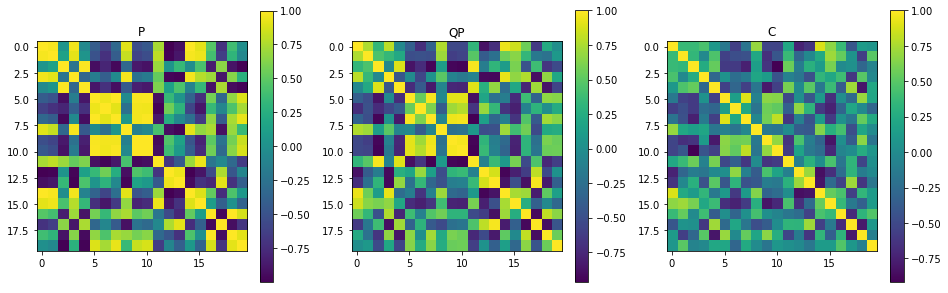

In [45]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.imshow(np.load("CorrmatrixperP.npy"))
plt.title("P")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.load("CorrmatrixperQP.npy"))
plt.title("QP")
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.load("CorrmatrixperC.npy"))
plt.title("C")
plt.colorbar()

In [134]:
@interact(om = (0,90,1))
def show(om):
    #same colormap-range for every omega
    #
    plt.imshow(chi_om[om])
    plt.show()

interactive(children=(IntSlider(value=45, description='om', max=90), Output()), _dom_classes=('widget-interact…

In [27]:
np.save("Chi90x20x20",chi_om)


In [54]:
gg = 0.8
d,m = simulateNumb(0.1,15000,10,gg,30000)
chi_om =np.load("Chi/Chi20x20_g{}x5.npy".format(gg))
chi_om_qp =np.load("Chi/Chi20x20_g0.45x5.npy".format(gg))

In [56]:
@interact_manual(ii=range(5),i0=range(5),rang=ipywidgets.IntRangeSlider(min=8,max=48,step=1,value=[8,48]))
def compareChiFFT(ii,i0,rang):
    plt.figure(figsize=(13,4))
    plt.subplot(1,1,1)
    plt.title(f"{ii} {i0}")
    plotfft(m,50)
    plt.plot(1000*(omegas/pii),chi_om[:,ii,i0]/np.max(chi_om[:,ii,i0]),linewidth=3)
    #plt.plot(1000*(omegas/pii),chi_om_qp[:,ii,i0]/np.max(chi_om_qp[:,ii,i0]),linewidth=3)
    plt.xlim(rang[0],rang[1])
    plt.xlabel("$\\omega$")
    #plt.ylabel("$\\chi$")
    plt.tight_layout()

interactive(children=(Dropdown(description='ii', options=(0, 1, 2, 3, 4), value=0), Dropdown(description='i0',…

In [62]:
len(np.arange(0.05,0.5,0.0001))

4500

In [61]:
len(m)

120000

In [44]:
#J2 con 0.15  =  Periodic ~ 0.45 = quasi periodic ~ 0.8 = chaotic
#J3 con 1.45 estable
i0 = 2
i = 3
eps = 0.01
omega = 5



In [250]:
d,m = simulateNumb(0.1,15000,10,0.15,30000)

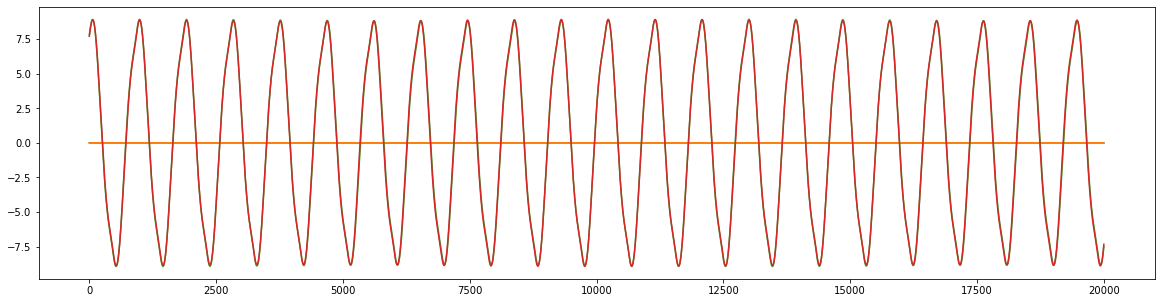

In [45]:
i0=2
om = 0.01
eps = 0.01
(d1,d2),(m1,m2)= simulateNumbV(0.1,15000,10,0.15,om,2,eps,30000)
plt.figure(figsize=(20,5))
plt.plot(np.array([S2(omega,t,i0,eps) for t in np.arange(0,2000,0.1)])[:,i0])
plt.plot(np.array([S1(omega,t,i0,eps) for t in np.arange(0,2000,0.1)])[:,i0])
plt.plot(d1[:20000,2])
plt.plot(d2[:20000,2])
plt.show()

In [16]:
from joblib import Parallel, delayed
from time import time

In [40]:
def function(x):
    for n in range(1000000):
        value = np.random.random()
    print(value)
    return value+x
#Parallel(n_jobs=2)(delayed(function)(i) for i in range(10))

In [36]:
a = time()
list(map(function,range(100)))
print(time()-a)

0.7436292499026619
0.4445664724992895
0.7377465471353019
0.08622946404328868
0.05979781896575864
0.737235630989466
0.3664829394952187
0.3553298495166748
0.6076662876242184
0.3745396751243688
0.9134911305107817
0.4223662753432669
0.15245606346577334
0.4324897885516322


KeyboardInterrupt: 

In [41]:
a = time()
oup = Parallel(n_jobs=30)(delayed(function)(i) for i in range(100))
print(time()-a)

3.1362528800964355


In [42]:
oup

[0.41544916171108537,
 1.0975329133182554,
 2.5663563341892877,
 3.100300695623454,
 4.6140929832186846,
 5.070543719052902,
 6.937131509147802,
 7.1320915925351835,
 8.955680588285475,
 9.799451338413967,
 10.838362470533347,
 11.354969308266664,
 12.581867233935208,
 13.825156420456803,
 14.43822667694886,
 15.439347789978452,
 16.518735892658743,
 17.850656357675497,
 18.674002562083494,
 19.20881791056845,
 20.535250263977407,
 21.78703143995729,
 22.793058504929355,
 23.982173440398356,
 24.889597361445766,
 25.609063213968675,
 26.519202804157487,
 27.959626993184127,
 28.710559643059742,
 29.857794605930163,
 30.536823728631177,
 31.740233670115977,
 32.05727131255807,
 33.32274246214428,
 34.55625238119288,
 35.204296483083105,
 36.364486904949395,
 37.43614483349189,
 38.6293088704165,
 39.39270851709992,
 40.53972407097244,
 41.785337837144155,
 42.636198652363646,
 43.12204672247926,
 44.1019748687319,
 45.27314243779753,
 46.177795298492356,
 47.007254416655954,
 48.8285873